In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [3]:
#import data
dfmain = pd.read_csv("dat/reincidenciaJusticiaMenors.csv",low_memory=False)
dfmain.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [4]:
## Main crime of first recidivism: start in 2010 until 2013
##df.V117_rein_data_fet_2013 

## Date of first recidivism: start in 2010 until 2015
##df.V101_rein_data_fet_2015.value_counts() #I think this is the same as V117 but measured in 2015

##Try to get the timeframe of this data
##date of main crime
[np.min(dfmain.V22_data_fet), np.max(dfmain.V22_data_fet)]

['01-Apr-2005', '31-Oct-2009']

This suggests, that crimes were committed between April 2005 and October 2009.
Then, there were two follow ups, one in 2013 and the other in 2015 about recidivism status.

In [5]:
#df['V56_@R1_resum_risc_global_reverse'].isnull().sum() #3895
#df['V57_@R2_resum_risc_delictes_violents'].isnull().sum() #4396
#df['V58_@R3_resum_risc_violencia_centre'].isnull().sum() #4622
#df['V59_@R4_resum_risc_sortides_permisos'].isnull().sum() #4617
#df['V60_SAVRY_total_score'].isnull().sum() #3895
#print(df[['V56_@R1_resum_risc_global_reverse','V60_SAVRY_total_score']]) ##These two columns do not correspond
#df['V60_SAVRY_total_score'].loc[df.V60_SAVRY_total_score==99.0].sum()/99
#df.V60_SAVRY_total_score.value_counts()


In [6]:
##1. Aequitas data Score = SAVRRY total score

dfmain = dfmain.rename(index=str, columns={"V2_estranger": "foreigner", "V1_sexe": "sex","V60_SAVRY_total_score": "full_score", \
                                  "V115_reincidencia_2015":'recid', "V4_nacionalitat_agrupat":"national_group", \
                                  "V5_edat_fet_agrupat":"age_group","V6_provincia":"province","V9_edat_final_programa": \
                                  "age_final", "V11_antecedents":"prior_crime", "V12_nombre_ante_agrupat": \
                                   "prior_crimerec","V13_nombre_fets_agrupat": "prior_crimes", "V15_fet_agrupat": \
                                  "crime_maincat", "V16_fet_violencia": "crime_violence", "V17_fet_tipus":"crime_type" \
                                  })
dfmain['label_value'] = dfmain.recid == 'Sí'
dfmain.national_group=dfmain.national_group.fillna('Spanish')
dfaequi=dfmain[['id','label_value','full_score','foreigner','sex','national_group','age_group','province','age_final', \
            'prior_crime','prior_crimerec','prior_crimes','crime_maincat','crime_violence', 'crime_type' ]]
dfaequi = dfaequi[np.isfinite(dfaequi['full_score'])]
dfaequi = dfaequi.loc[dfaequi['full_score']!=99]
dfaequi.age_group=dfaequi.age_group.fillna('16 i 17 anys') #replaced here missings by higher age group because final age is high


###save the datasets dfaequi and dfmain
save_object(dfmain, 'dat/dfmain.pkl')
save_object(dfaequi, 'dat/dfaequi.pkl')


df = dfaequi
del dfaequi


##Value counts
N=len(df)
df.head()

,id,label_value,full_score,foreigner,sex,national_group,age_group,province,age_final,prior_crime,prior_crimerec,prior_crimes,crime_maincat,crime_violence,crime_type
0,691,True,30.0,Espanyol,Home,Spanish,14 i 15 anys,Lleida,17,Amb antecedents,1 o 2 antecedents,3 fets o més,Contra les persones,Violent,Delicte
1,956,True,27.0,Espanyol,Dona,Spanish,14 i 15 anys,Barcelona,15,Amb antecedents,1 o 2 antecedents,2 fets,Contra les persones,Violent,Delicte
2,2560,True,26.0,Estranger,Home,Magrib,14 i 15 anys,Barcelona,16,Amb antecedents,De 3 a 5 antecedents,3 fets o més,Contra les persones,Violent,Delicte
3,2018,True,35.0,Estranger,Home,Magrib,14 i 15 anys,Girona,15,Amb antecedents,Més de 5 antecedents,2 fets,Contra les persones,Violent,Delicte
4,1650,True,31.0,Espanyol,Home,Spanish,16 i 17 anys,Tarragona,20,Amb antecedents,Més de 5 antecedents,3 fets o més,Contra les persones,Violent,Delicte


This is the first specification of the current analysis. The SAVRY score yields information for 855 individuals of which 747 are male and 108 are female. Of these 855, 524 are spanish and 331 are foreign. The label indicates whether the person, wo committed a crime between 2005 and 2009, recidiviated any time between 2010 and 2015. I use as risk score the "SAVRY" total sum of risk of 24 risk scores (TSS). Each indicator is either 0 for low, 1 for intermediate and 2 for high. Thus, the maximum possible TSS is 48 but in this sample the maximum TSS is 40. I do some short exploratory analysis based on the full distribution of the risk score but then classify into a binary indicator which is 0, i.e. low if the TSS is below 20 and 1 if the TSS is greater than or equal to 20. I conduct some fairness analysis for sex and nationality status (i.e. foreign, not foreign)

In [7]:
#Reduce score to a binary variable
df['score']=df['full_score']>=20
df.score.value_counts()

False    576
True     279
Name: score, dtype: int64

The overall recidivism rate is 33% for the total SAVRY sample

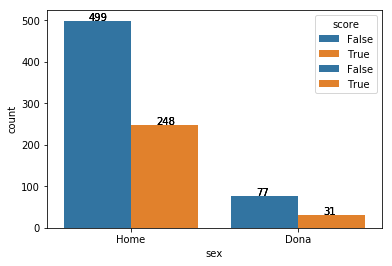

In [9]:
###Exploratory analysis
#as in the aequitas tutorial
ax = sns.countplot(x="sex", hue="score", data=df)
total = float(len(df)) # one person per row 

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show()

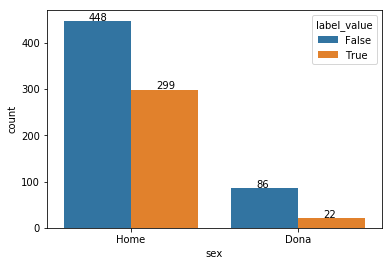

In [10]:
ax = sns.countplot(x="sex", hue="label_value", data=df)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show()

The distribution of a high SAVRY risk scores across sex (28% for females and 33% for males) compared to the distribution of recidivism base rates across sex (20% for females and 40% for males) suggests that recidivism risk for females might be overpredicted while being underpredicted for males. This follows the own definition of a high TSS. Repeat this analysis with the variable "V56_@R1_resum_risc_global_reverse". This variable deviates from the TSS. Q: How do these two labels correspond? 

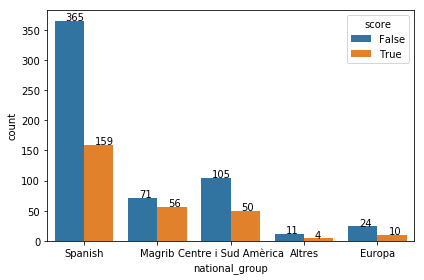

In [11]:
#Distribution of risk scores foreign / not foreign
ax = sns.countplot(x="national_group", hue="score", data=df)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.tight_layout()
plt.show()

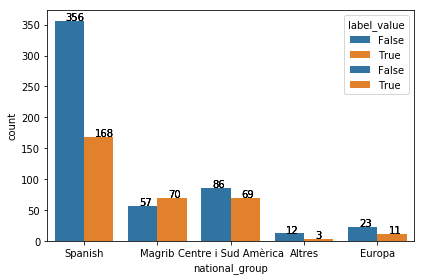

In [13]:
#Distribution of label_value foreign, not foreign
ax = sns.countplot(x="national_group", hue="label_value", data=df)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.tight_layout()
plt.show()

The distribution of a high TSS across nationality suggests that recidivism risk for people from maghrib, central or south america and even spanish might be overpredicted. Repeat this analysis with the variable "V56_@R1_resum_risc_global_reverse". This variable deviates from the TSS. Q: How do these two labels correspond? 

In [537]:
list(df)

['id',
 'label_value',
 'full_score',
 'foreigner',
 'sex',
 'national_group',
 'age_group',
 'province',
 'age_final',
 'prior_crime',
 'prior_crimerec',
 'prior_crimes',
 'crime_maincat',
 'crime_violence',
 'crime_type',
 'score']

In [14]:
##drop variables that do not work with the aequitas library
df = df.drop(['full_score'], axis = 1)
##also, first drop categorical variables with missings
df = df.drop(['province'], axis = 1)
df = df.drop(['prior_crimerec'], axis = 1)
df = df.drop(['age_final'], axis = 1)
df = df.drop(['prior_crime'], axis = 1)

In [15]:
df.dtypes

id                 int64
label_value         bool
foreigner         object
sex               object
national_group    object
age_group         object
prior_crimes      object
crime_maincat     object
crime_violence    object
crime_type        object
score               bool
dtype: object

In [16]:
#Prepare data for Aequias
##set every attribute column to category type
df['national_group'].isnull().sum()
df['prior_crimes'].isnull().sum()
df['crime_maincat'].isnull().sum()
df['crime_violence'].isnull().sum()
df['crime_type'].isnull().sum()
df['score'].isnull().sum()
#df['score']=df['score'].astype('int')
#df['label_value']=df['label_value'].astype('int')

0

In [17]:
###Run Aequitas-Analysis
#first: with binary score variable
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [279]}
COUNTS::: foreigner
Espanyol     524
Estranger    331
dtype: int64
COUNTS::: sex
Dona    108
Home    747
dtype: int64
COUNTS::: national_group
Altres                   15
Centre i Sud Amèrica    155
Europa                   34
Magrib                  127
Spanish                 524
dtype: int64
COUNTS::: age_group
14 i 15 anys    273
16 i 17 anys    582
dtype: int64
COUNTS::: prior_crimes
1 fet           507
2 fets          199
3 fets o més    149
dtype: int64
COUNTS::: crime_maincat
Altres                            115
Contra la propietat no violent    219
Contra la propietat violent       235
Contra les persones               286
dtype: int64
COUNTS::: crime_violence
No violent    334
Violent       521
dtype: int64
COUNTS::: crime_type
Delicte    719
Falta      136
dtype: int64


In [18]:
# Here's a subset of the crosstab data
xtab[['attribute_name', 'attribute_value', 'fpr', 'fnr', 'tpr', 'tnr', 'for', 'fdr', 'group_size']].round(2)

,attribute_name,attribute_value,fpr,fnr,tpr,tnr,for,fdr,group_size
0,foreigner,Espanyol,0.26,0.60,0.40,0.74,0.27,0.57,524
1,foreigner,Estranger,0.27,0.53,0.47,0.73,0.38,0.40,331
2,sex,Dona,0.23,0.50,0.50,0.77,0.14,0.65,108
3,sex,Home,0.27,0.57,0.43,0.73,0.34,0.48,747
4,national_group,Altres,0.25,0.67,0.33,0.75,0.18,0.75,15
5,national_group,Centre i Sud Amèrica,0.23,0.57,0.43,0.77,0.37,0.40,155
6,national_group,Europa,0.17,0.45,0.55,0.83,0.21,0.40,34
7,national_group,Magrib,0.37,0.50,0.50,0.63,0.49,0.38,127
8,national_group,Spanish,0.26,0.60,0.40,0.74,0.27,0.57,524
9,age_group,14 i 15 anys,0.28,0.55,0.45,0.72,0.40,0.42,273


In [545]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, {'national_group':'Spanish', 'sex':'Home', 'prior_crimes':'1 fet', \
                                              'age_group': '14 i 15 anys','crime_maincat': \
                                               'Contra la propietat no violent', \
                                              'crime_violence':'No violent','crime_type':'Delicte', \
                                               'foreigner': 'Espanyol' })

get_disparity_predefined_group()


In [547]:
bdf.columns

Index(['attribute_name', 'attribute_value', 'k', 'model_id', 'score_threshold',
       'tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv', 'precision', 'pp',
       'pn', 'ppr', 'pprev', 'fp', 'fn', 'tn', 'tp', 'group_label_neg',
       'group_label_pos', 'group_size', 'total_entities', 'prev',
       'ppr_disparity', 'pprev_disparity', 'precision_disparity',
       'fdr_disparity', 'for_disparity', 'fpr_disparity', 'fnr_disparity',
       'tpr_disparity', 'tnr_disparity', 'npv_disparity',
       'ppr_ref_group_value', 'pprev_ref_group_value',
       'precision_ref_group_value', 'fdr_ref_group_value',
       'for_ref_group_value', 'fpr_ref_group_value', 'fnr_ref_group_value',
       'tpr_ref_group_value', 'tnr_ref_group_value', 'npv_ref_group_value'],
      dtype='object')

In [548]:
bdf[['attribute_name', 'attribute_value', 'ppr_disparity', 'pprev_disparity', 'fdr_disparity', 'for_disparity',
       'fpr_disparity', 'fnr_disparity']]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity
0,foreigner,Espanyol,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,foreigner,Estranger,0.754717,1.194779,0.698901,1.401185,1.054945,0.889412
2,sex,Dona,0.125000,0.864583,1.344538,0.419328,0.875513,0.879412
3,sex,Home,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,national_group,Altres,0.025157,0.878826,1.310440,0.663636,0.978022,1.120000
5,national_group,Centre i Sud Amèrica,0.314465,1.063096,0.698901,1.355714,0.909788,0.949565
6,national_group,Europa,0.062893,0.969293,0.698901,0.760417,0.680363,0.763636
7,national_group,Magrib,0.352201,1.453177,0.655220,1.799296,1.441296,0.840000
8,national_group,Spanish,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,age_group,14 i 15 anys,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [549]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [550]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_group,False,True,False,True,False,True,True,True,True,False,False,False,True,False,False
1,1,binary 0/1,crime_maincat,False,False,True,False,False,False,False,True,True,True,False,False,False,False,False
2,1,binary 0/1,crime_type,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
3,1,binary 0/1,crime_violence,False,False,True,False,True,True,False,True,True,True,False,True,False,False,False
4,1,binary 0/1,foreigner,False,True,False,True,False,True,True,True,True,False,False,False,True,False,False
5,1,binary 0/1,national_group,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
6,1,binary 0/1,prior_crimes,False,False,True,False,False,False,False,True,True,True,False,False,False,False,False
7,1,binary 0/1,sex,False,True,False,True,False,True,True,True,False,False,False,False,True,False,False


In [551]:
fdf[['attribute_name', 'attribute_value','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOR Parity', 'FNR Parity',
       'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]

,attribute_name,attribute_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TypeI Parity,TypeII Parity,Unsupervised Fairness,Supervised Fairness
0,foreigner,Espanyol,True,True,True,True,True,True,True,True,True,True
1,foreigner,Estranger,False,True,False,True,False,True,False,False,False,False
2,sex,Dona,False,True,False,True,False,True,False,False,False,False
3,sex,Home,True,True,True,True,True,True,True,True,True,True
4,national_group,Altres,False,True,False,True,False,True,False,False,False,False
5,national_group,Centre i Sud Amèrica,False,True,False,True,False,True,False,False,False,False
6,national_group,Europa,False,True,False,False,False,False,False,False,False,False
7,national_group,Magrib,False,False,False,False,False,True,False,False,False,False
8,national_group,Spanish,True,True,True,True,True,True,True,True,True,True
9,age_group,14 i 15 anys,True,True,True,True,True,True,True,True,True,True


In [554]:
##Repeat this analysis but with another risk classfication
len(dfmain)
dfmain['V56_@R1_resum_risc_global_reverse'].value_counts()
384+327+147

858